In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load datasets

In [33]:
pressures_no_leakage3h_mean = pd.read_csv("../data/aggregation/pressures_aggregated_scenario1.csv")
flows_no_leakage3h_mean = pd.read_csv("../data/aggregation/flows_aggregated_scenario1.csv")

pressures_no_leakage3h_mean["Timestamp"] = pd.to_datetime(pressures_no_leakage3h_mean["Timestamp"])
flows_no_leakage3h_mean["Timestamp"] = pd.to_datetime(flows_no_leakage3h_mean["Timestamp"])

pressures_no_leakage3h_mean.set_index("Timestamp", inplace=True)
flows_no_leakage3h_mean.set_index("Timestamp", inplace=True)

# Train SARIMA model on scenario without leakage

SARIMA model is an extension of the ARIMA model (_Auto Regressive Integrated Moving Average_). To understand how SARIMA works, we have to understand first what is an ARIMA model.  \
An ARIMA model is a form of regression apply on time series. The goal of the model is to predict future values by looking on the relation between a value and its predecessors.  \
To do that, we train the model on historical data in order to learn this relation and to forecast it on future points.  \
An ARIMA model is composed by three components : 
- Auto Regressive component (AR)
- Integrated component (I)
- Moving Average component (MA)

Let's explain what each component is for : 

**Auto Regressive (AR)**

The *Auto Regressive* part of the model is based on the idea that the variable depends on past values of itself. \
If we try to modelize it by a function, we have this result :  \
$$
y_{t} = \phi_{t-1}y_{t-1}+~.~.~.~+\phi_{t-p}y_{t-p}+\epsilon_{t}+\beta_{1}
$$

Where $\epsilon_{t}$ is a residue approached by a normal law with 0 mean and a certain variance :  \
$$
\epsilon_{t} \sim \mathcal{N}(0,\,\sigma^{2})
$$

and $\beta_{1}$ is a constant

On the first equation, we consider that the $y_{t}$ value depends of past values until $p$ times. This is why the *Auto Regressive* part of ARIMA is written *AR($p$)* where $p$ is the number of past values needed to approach the actual value. We will see later how to chose $p$.

**Integrated (I)**

The *Integrated* part is the number of differenciations we need to have our time serie *stationnary*.  \
*Stationnarity* is needed to forecast a time serie. A serie is stationnary if its statistical metrics (like *mean* or *standard deviation*) don't change over time.  \
Differenciate a time serie is a general way to transform it into a stationnary serie.  \
The differenciation at the first order is given by:  \
$$
\Delta y_{t} = y_{t} - y_{t-1}
$$
More generally, the differenciation at the $d$ order is given by:  \
$$
\Delta y_{t} = y_{t} - y_{t-1} -~.~.~.~-(y_{t-d-1} - y_{t-d})
$$
This is why the *Integrated* part is written *I($d$)*.  \
To check if a serie is *stationnary* or if we have to differenciate it, we apply the *Augmented Dick Fuller* test (ADF) to this serie. The null hypotesis is that the serie is not stationnary. If the $p\_value$ of the test is less than 0.05 and the $adf\_value$ is less than the critical value at $5\%$, we reject the null hypotesis and the serie is *stationnary*, otherwise we can't reject it and the serie is not *stationnary*.  \
We will apply the ADF test on our time series in order to find the differenciation we need in our SARIMA model.

**Moving Average (MA)**

The *Moving Average* part is based on the error we did in predicting values for the previous values to make a better estimate for the current value.  \
The mathematical formula of this part is:  \
$$
y_{t} = \beta_{2} + \omega_{t-1}\epsilon_{t-1}+~.~.~.~+\omega_{t-q}\epsilon_{t-q}
$$

Where $\beta_{2}$ is a constant and all the $\epsilon$ are the errors oberserved at the $i^{th}$ value

On the equation, we consider that the $y_{t}$ value depends of past errors until $q$ times. This is why the *Moving Average* part of ARIMA is written *MA($q$)* where $q$ is the number of past errors needed to approach the actual value. We will see later how to chose $q$.

**ARIMA model**

To conclude, an **ARIMA** model is a combination of *AR($p$)*, *I($d$)* and *MA($q$)*. This is why we note *ARIMA($p$, $d$, $q$)*.  \
The mathematical formula of the *ARIMA* model is:  \
$$
y_{t} = (\beta_{1} + \beta_{2}) + (\phi_{t-1}y_{t-1}+~.~.~.~+\phi_{t-p}y_{t-p})+(\omega_{t-1}\epsilon_{t-1}+~.~.~.~+\omega_{t-q}\epsilon_{t-q})
$$
where $y_{t}$ can be differenciate at the $d$ order.

**S part of SARIMA**

The *S* part of *SARIMA* is for *seasonality*. The problem with *ARIMA* model is that it does not support *seasonality*. *Seasonal Autoregressive Integrated Moving Average* (*SARIMA* or *Seasonal ARIMA*) is an extension of *ARIMA* that explicitly supports univariate time series data with a seasonal component.  \
We note this model *SARIMA($p$, $d$, $q$, $m$)* where $m$ is the number of time steps for a single seasonal period.

**How to choose $p$, $d$, $q$ and $m$ ?**

To choose the $p$ parameter, we observe the *Partial Auto Correlation* graph and choose the ultimate $p$ number before the *Partial Auto Correlation Factor* become unsignificant (between the 95% confidence interval).  \
We do the same to choose the $q$ parameter, except that we use the *Auto Correlation* graph.  \
We have said how to choose the $d$ parameter.  \
To choose the $m$ parameter, we observe the data and try to determine the *seasonality* information. In our study, we can consider that the data have a one day *seasonality*, and so $m=8$ (because we have 1 point each 3 hours)

**Objective of the training**

The objective of the training part (or fitting part) is to determine the best $\phi$ parameters and the best $\omega$ parameters of the *SARIMA* (or *ARIMA*) function. To do so, we use an optimisation algorithm (*LBFGS, Newton Raphson, Gradient Descent*) to minimize the distance between the predicted value and the real value

First of all, we have to check if our time series (*pressures* and *flows*) are stationary:

## Check stationarity

We apply the ADF test to our 2 time series to check if they are stationnary or not

In [5]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print("the serie is stationary")
    else:
        print("the serie is NOT stationary")

In [6]:
print("Pressure node 21")
check_stationarity(pressures_no_leakage3h_mean["node_21_mean"])

Pressure node 21
1. ADF :  -3.1368292796909993
2. P-Value :  0.02394501502681976
3. Num Of Lags :  28
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2891
5. Critical Values :
	 1% :  -3.4326139625732837
	 5% :  -2.862540266114088
	 10% :  -2.5673024702995892
the serie is stationary


In [7]:
print("Flow link 21")
check_stationarity(flows_no_leakage3h_mean["link_21_mean"])

Flow link 21
1. ADF :  -3.0881478048400806
2. P-Value :  0.027442828456598605
3. Num Of Lags :  28
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2891
5. Critical Values :
	 1% :  -3.4326139625732837
	 5% :  -2.862540266114088
	 10% :  -2.5673024702995892
the serie is stationary


According to the ADF test, the 2 time series at the differenciation 0 are stationnary

So we have 
$
d = 0 
$
for the 2 models

## Plot PACF to determine the p parameter

### Pressures

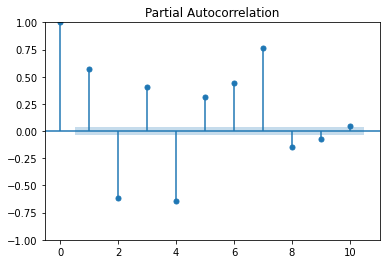

In [10]:
plot_pacf(pressures_no_leakage3h_mean["node_21_mean"], lags=10, method="ywm")
plt.show()

We can see that the ultimate point before the factor become unsignificant is 7, we choose for the *pressures SARIMA* model the value of 7 for $p$:  
$
p=7
$

### Flows

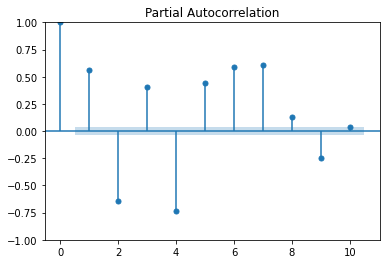

In [11]:
plot_pacf(flows_no_leakage3h_mean["link_21_mean"], lags=10, method="ywm")
plt.show()

We can see that the ultimate point before the factor become unsignificant is 7, we choose for the *flows SARIMA* model the value of 7 for $p$:  \
$
p=7
$

## Plot ACF to determine the q parameter

### Pressures

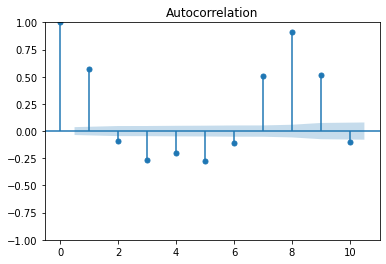

In [12]:
plot_acf(pressures_no_leakage3h_mean["node_21_mean"], lags=10)
plt.show()

We can see that the ultimate point before the factor become unsignificant is 9, we choose for the *pressures SARIMA* model the value of 9 for $q$:  \
$
q=9
$

### Flows

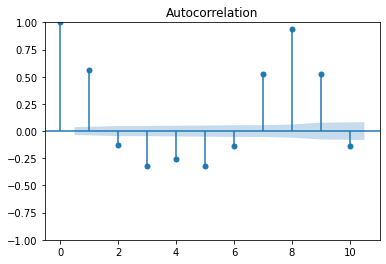

In [13]:
plot_acf(flows_no_leakage3h_mean["link_21_mean"], lags=10)
plt.show()

We can see that the ultimate point before the factor become unsignificant is 9, we choose for the *flows SARIMA* model the value of 9 for $q$:  \
$
q=9
$

## Conclusion

We have the same *SARIMA* model for pressures and flows:  \
$
SARIMA(7, 0, 9, 8)
$

## Train model on node and link on no leakage data

### Pressures model

In [42]:
model_node_21=SARIMAX(
    pressures_no_leakage3h_mean["node_21_mean"],
    seasonal_order=(7, 0, 9, 8),
)
model_21_fit=model_node_21.fit(maxiter=1000, disp=False)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Plot forecasting on training set

Text(0.5, 1.0, 'Pressures forecasting on training set')

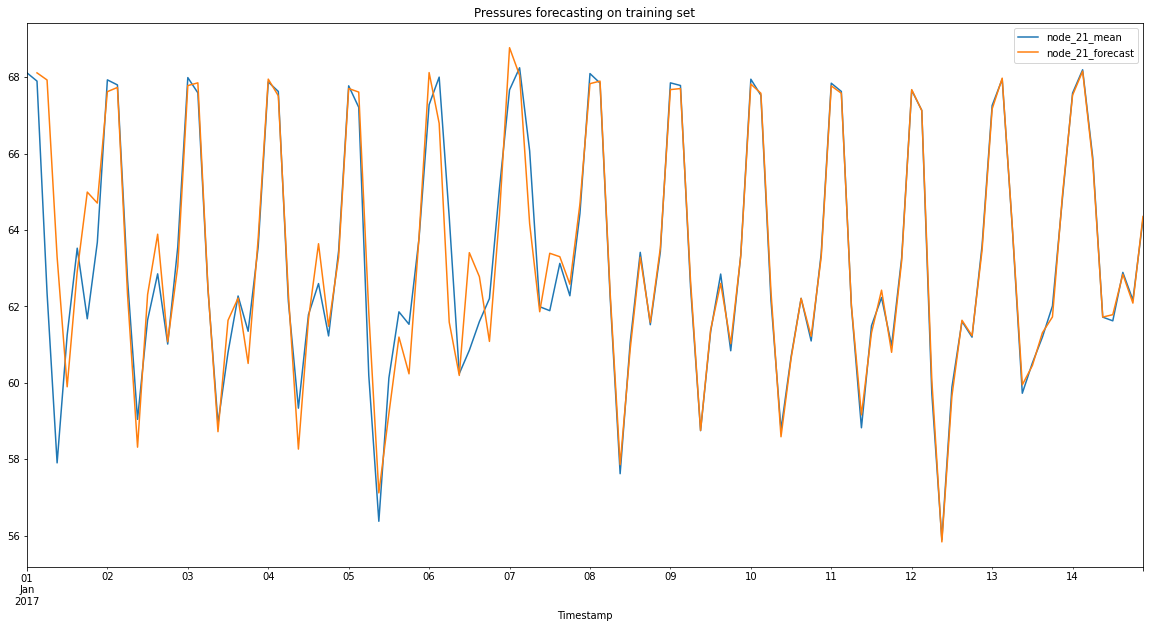

In [43]:
pressures_no_leakage3h_mean["node_21_forecast"]=model_21_fit.predict(start=1,end=2920,dynamic=False)
pressures_no_leakage3h_mean[pressures_no_leakage3h_mean.index < "2017-01-15 00:00:00"][['node_21_mean','node_21_forecast']].plot(figsize=(20,10))
plt.title("Pressures forecasting on training set")

We see with this plot that the trained SARIMA model can forecast with a good precision our time serie.

## Flows model

In [56]:
model_link_21=SARIMAX(
    flows_no_leakage3h_mean["link_21_mean"],
    seasonal_order=(7, 0, 9, 8), 
)
model_link_21_fit=model_link_21.fit(maxiter=30, disp=False)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Plot forecasting on training set

Text(0.5, 1.0, 'Flows forecasting on training set')

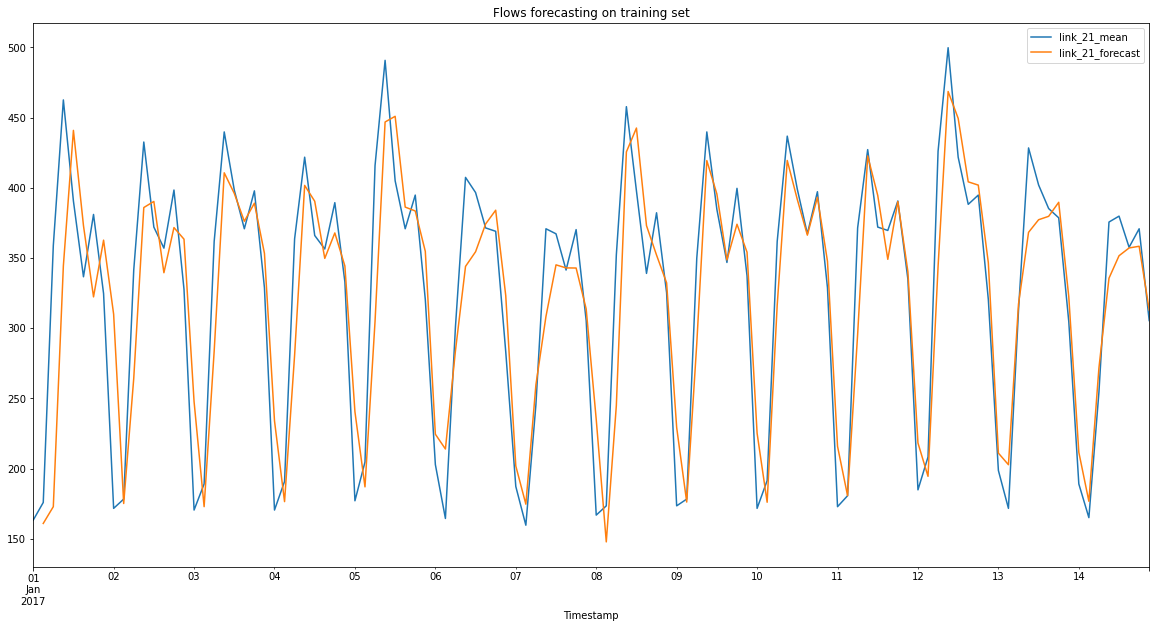

In [57]:
flows_no_leakage3h_mean["link_21_forecast"]=model_link_21_fit.predict(start=1,end=2920,dynamic=False)
flows_no_leakage3h_mean[flows_no_leakage3h_mean.index < "2017-01-15 00:00:00"][['link_21_mean','link_21_forecast']].plot(figsize=(20,10))
plt.title("Flows forecasting on training set")

## Plot forecasting on scenario with anomalies

### Scenario 5

In [60]:
pressures_leakage3h_mean = pd.read_csv('../data/aggregation/pressures_aggregated_scenario5.csv')
pressures_leakage3h_mean["Timestamp"] = pd.to_datetime(pressures_leakage3h_mean["Timestamp"])
pressures_leakage3h_mean.set_index("Timestamp", inplace=True)

flows_leakage3h_mean = pd.read_csv('../data/aggregation/flows_aggregated_scenario5.csv')
flows_leakage3h_mean["Timestamp"] = pd.to_datetime(flows_leakage3h_mean["Timestamp"])
flows_leakage3h_mean.set_index("Timestamp", inplace=True)

#### Pressures

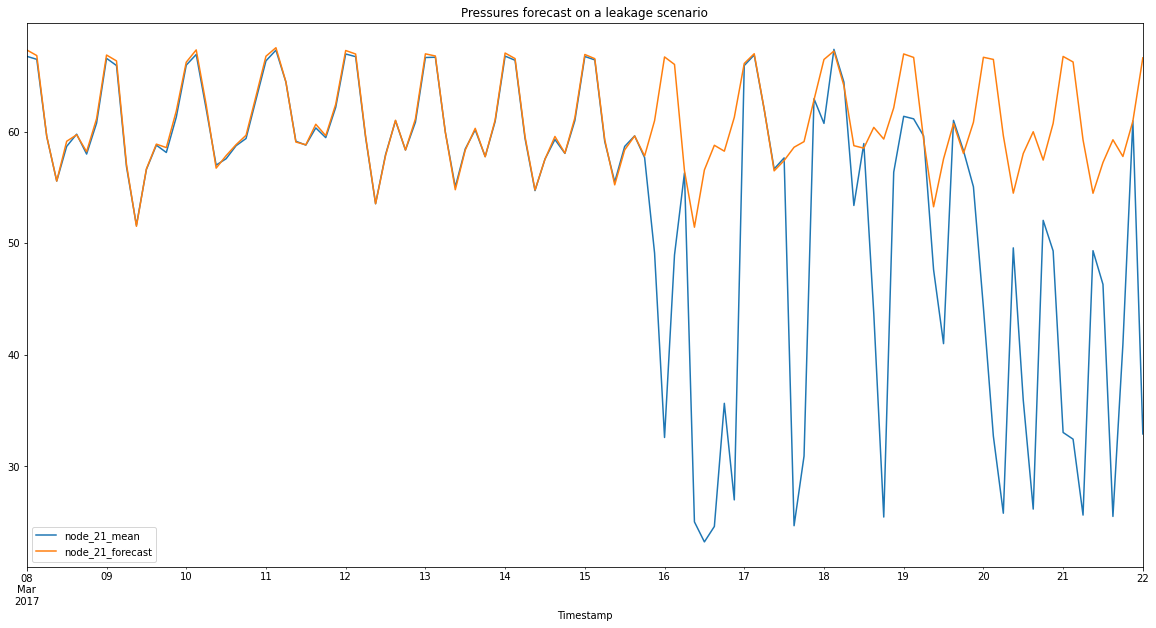

In [63]:
pressures_leakage3h_mean["node_21_forecast"]=model_21_fit.predict(start=1,end=2920,dynamic=550)
pressures_leakage3h_mean[
    (pressures_leakage3h_mean.index >= "2017-03-08 00:00:00") &
    (pressures_leakage3h_mean.index <= "2017-03-22 00:00:00")
][['node_21_mean','node_21_forecast']].plot(figsize=(20,10))
plt.title("Pressures forecast on a leakage scenario")
plt.show()

#### Flows

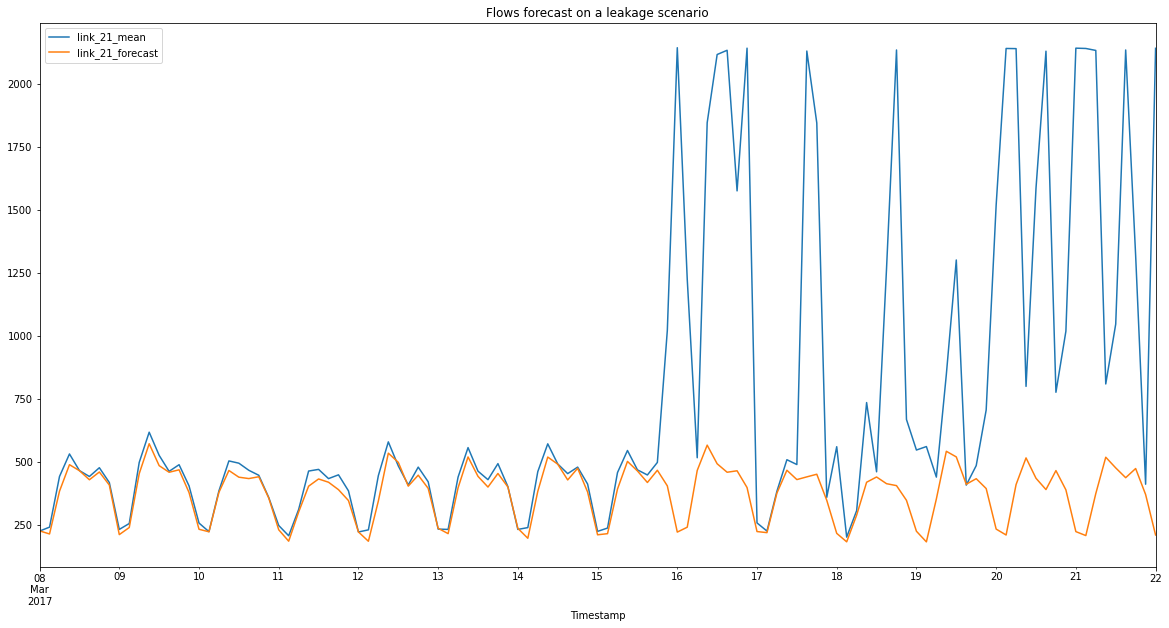

In [64]:
flows_leakage3h_mean["link_21_forecast"]=model_link_21_fit.predict(start=1,end=2920,dynamic=False)
flows_leakage3h_mean[
    (flows_leakage3h_mean.index >= "2017-03-08 00:00:00") &
    (flows_leakage3h_mean.index <= "2017-03-22 00:00:00")
][['link_21_mean','link_21_forecast']].plot(figsize=(20,10))
plt.title("Flows forecast on a leakage scenario")
plt.show()

### Scenario 78

In [65]:
pressures_leakage2_3h_mean = pd.read_csv('../data/aggregation/pressures_aggregated_scenario78.csv')
pressures_leakage2_3h_mean["Timestamp"] = pd.to_datetime(pressures_leakage2_3h_mean["Timestamp"])
pressures_leakage2_3h_mean.set_index("Timestamp", inplace=True)

flows_leakage2_3h_mean = pd.read_csv('../data/aggregation/flows_aggregated_scenario78.csv')
flows_leakage2_3h_mean["Timestamp"] = pd.to_datetime(flows_leakage2_3h_mean["Timestamp"])
flows_leakage2_3h_mean.set_index("Timestamp", inplace=True)

#### Pressures

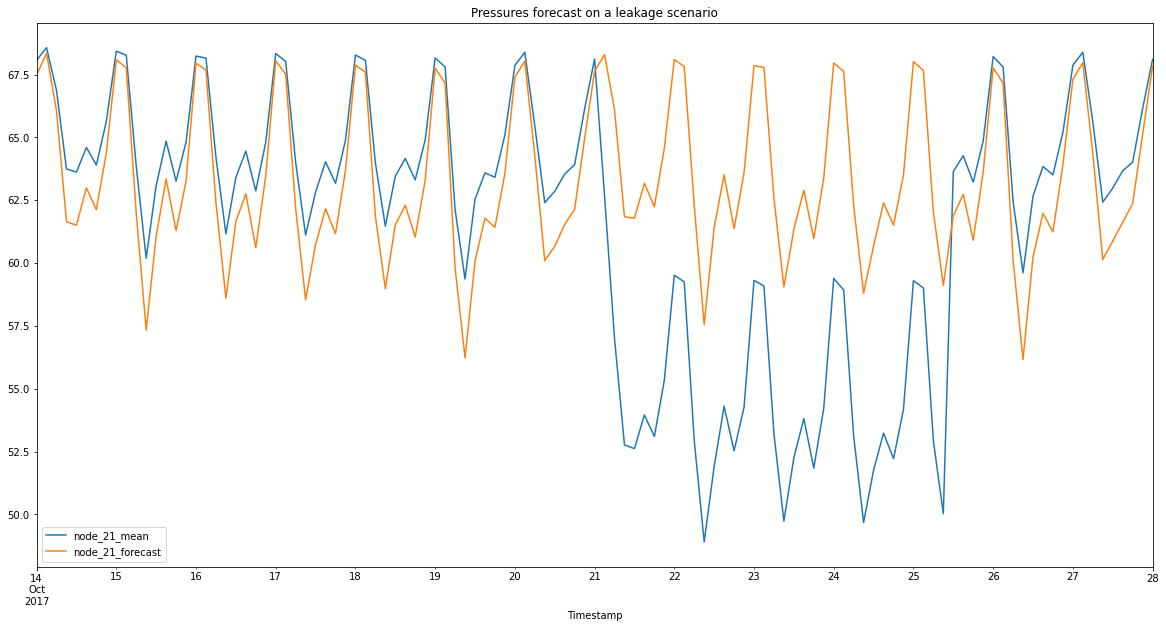

In [66]:
pressures_leakage2_3h_mean["node_21_forecast"]=model_21_fit.predict(start=1,end=2920,dynamic=False)
pressures_leakage2_3h_mean[
    (pressures_leakage2_3h_mean.index >= "2017-10-14 00:00:00") &
    (pressures_leakage2_3h_mean.index <= "2017-10-28 00:00:00")
][['node_21_mean','node_21_forecast']].plot(figsize=(20,10))
plt.title("Pressures forecast on a leakage scenario")
plt.show()

#### Flows

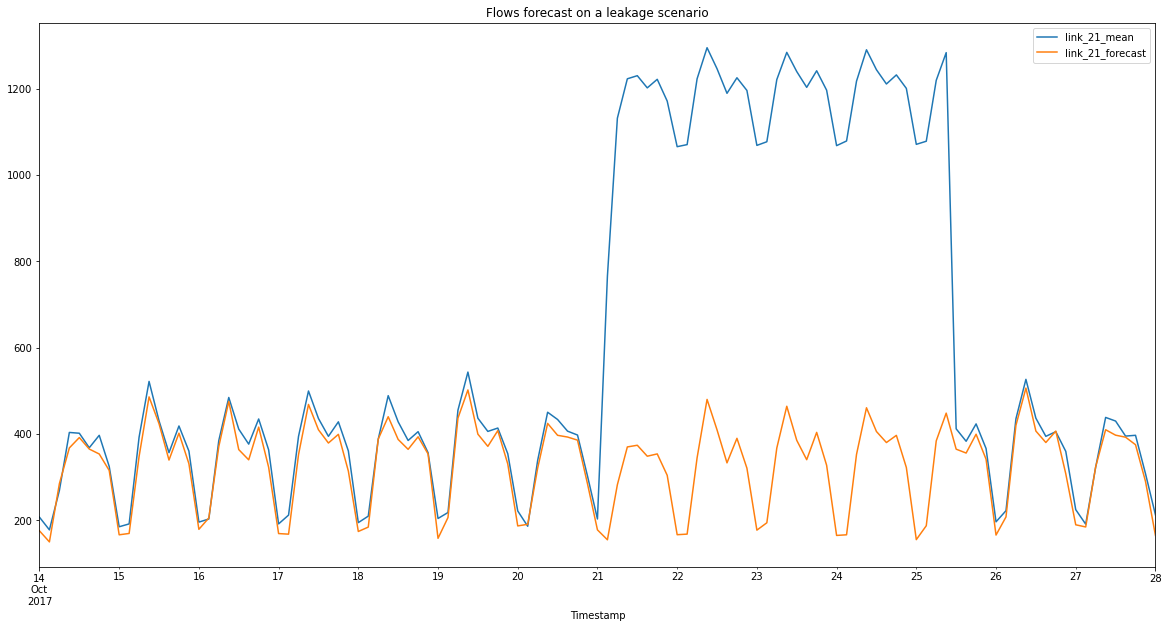

In [67]:
flows_leakage2_3h_mean["link_21_forecast"]=model_link_21_fit.predict(start=1,end=2920,dynamic=False)
flows_leakage2_3h_mean[
    (flows_leakage2_3h_mean.index >= "2017-10-14 00:00:00") &
    (flows_leakage2_3h_mean.index <= "2017-10-28 00:00:00")
][['link_21_mean','link_21_forecast']].plot(figsize=(20,10))
plt.title("Flows forecast on a leakage scenario")
plt.show()

We can easily see that the difference between the expected value (predicted) and the real value increases a lot when we have an anomaly

# Concatenate dataframes

We concatenate dataframes to obtain just one dataframe per physical phenomene (pressures and flows) to train later a supervised classification model

We shift datetime index in order to obtain a dataframe with data from 2017 to 2019

## Pressures

In [68]:
temp_pressures_leak = pressures_leakage3h_mean.reset_index().copy()
temp_pressures_leak["Timestamp"] = temp_pressures_leak["Timestamp"] + pd.offsets.DateOffset(years=1)
temp_pressures_leak.set_index("Timestamp", inplace=True)

temp_pressures_leak2 = pressures_leakage2_3h_mean.reset_index().copy()
temp_pressures_leak2["Timestamp"] = temp_pressures_leak2["Timestamp"] + pd.offsets.DateOffset(years=2)
temp_pressures_leak2.set_index("Timestamp", inplace=True)

pressures_df = pd.concat([pressures_no_leakage3h_mean, temp_pressures_leak,
                         temp_pressures_leak2], axis=0)
pressures_df["difference"] = np.abs(pressures_df["node_21_mean"] - pressures_df["node_21_forecast"])
pressures_df.fillna(0, inplace=True)

## Flows

In [70]:
temp_flows_leak = flows_leakage3h_mean.reset_index().copy()
temp_flows_leak["Timestamp"] = temp_flows_leak["Timestamp"] + pd.offsets.DateOffset(years=1)
temp_flows_leak.set_index("Timestamp", inplace=True)

temp_flows_leak2 = flows_leakage2_3h_mean.reset_index().copy()
temp_flows_leak2["Timestamp"] = temp_flows_leak2["Timestamp"] + pd.offsets.DateOffset(years=2)
temp_flows_leak2.set_index("Timestamp", inplace=True)

flows_df = pd.concat([flows_no_leakage3h_mean, temp_flows_leak, temp_flows_leak2], axis=0)
flows_df["difference"] = np.abs(flows_df["link_21_mean"] - flows_df["link_21_forecast"])
flows_df.fillna(0, inplace=True)

# Saving dataframes and SARIMA models

In [72]:
model_21_fit.save("../data/models/model_node_21_fit.pickle")
model_link_21_fit.save("../data/models/model_link_21_fit.pickle")

pressures_df.to_csv("../data/final_data/pressures_node21.csv")
flows_df.to_csv("../data/final_data/flows_link21.csv")